In [2]:
import numpy as np
import matplotlib.pyplot as plt

class NoisyLIFNeuron:
    def __init__(self, tau, R, threshold, sigma, dt=0.01):
        self.tau = tau  # Membrane time constant
        self.R = R      # Membrane resistance
        self.threshold = threshold  # Firing threshold
        self.sigma = sigma #Amplitude of the noise (in units of voltage)
        self.dt = dt    # Time step
        self.reset()

    def reset(self):
        self.voltage = 0.0  # Initial membrane potential

    def update(self, I):
        # Membrane potential update using Euler method
        dv = (-(self.voltage) + self.R * I) / self.tau * self.dt + self.sigma*np.sqrt(self.dt)*np.random.normal(0, 1)
        self.voltage += dv
        # Check for spike
        if self.voltage >= self.threshold:
            self.voltage = 0.0  # Reset membrane potential after spike
            return True
        else:
            return False

def simulate_neuron(I, tau, R, threshold, sigma, dt=0.01, duration=10):
    neuron = NoisyLIFNeuron(tau, R, threshold, sigma, dt)
    time = np.arange(0, duration, dt)
    spikes = []
    voltages = []
    for t in time:
        spike = neuron.update(I)
        voltages.append(neuron.voltage)
        if spike:
            spikes.append(t)
    return spikes, voltages


In [42]:
# Simulation parameters
tau = 4 # Membrane time constant (ms)
R = 1    # Membrane resistance
threshold = float('inf')  # Firing threshold
sigma = 0  #NO STOCHASTIC NOISE

dt = 0.01 # Time step (ms)
duration = 600  # Duration of simulation (ms)
t=np.arange(0, duration, dt)

I = 0  # Input current (arbitrary units)

lambda_hz = 10  # Rate of the Poisson process (in Hz)
lambda_ = lambda_hz/1e3  # Rate of the Poisson process (events per unit time (spikes/ms))
N_bg = 100
w = 0.1 #synaptic weight

def background(dt, t, N_background):
    bg = 0
    spikes_bg = []
    for j in range(N_background):
        # Generate Poisson process
        events = np.random.poisson(lambda_ * dt, len(t))
        events[events > 1] = 1  # Ensure at most one event per timestep

        #obtain spike times
        spikes_temp = events*t
        spike_times = spikes_temp[spikes_temp != 0]
        spikes_bg = np.concatenate((spikes_bg,spike_times))
        #presinaptic input
        epsilon=0
        for i in range(len(spike_times)):
            bg = bg + (((t-spike_times[i]))/tau)*np.exp(-(t-spike_times[i])/tau)*np.heaviside(t-spike_times[i],0.5)
    return bg, spikes_bg

bg, spikes_bg = background(dt,t, N_bg)
spikes, voltages = simulate_neuron(I, tau, R, threshold, sigma, dt, duration)

u0 = w*lambda_*N_bg*tau
u0_sd = np.sqrt(0.5*w**2*lambda_*N_bg*tau)

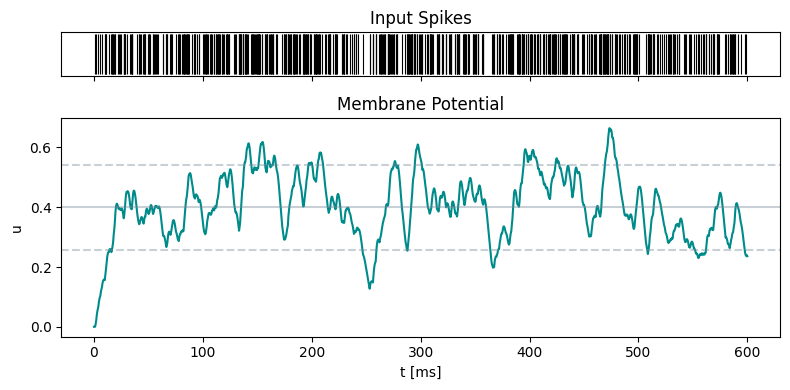

In [49]:
# Create figure and subplots with different aspect ratios
fig, axs = plt.subplots(2, 1, figsize=(8, 4), gridspec_kw={'height_ratios': [1, 5]}, sharex=True)

# Plot data on the first subplot
axs[0].vlines(spikes_bg, ymin=0, ymax=1, colors='black', linestyles='-', linewidth=0.8)
axs[0].set_title('Input Spikes')
# Hide y ticks and labels of the upper plot
axs[0].tick_params(axis='y', which='both', left=False, labelleft=False)
# Plot data on the second subplot
axs[1].plot(t, voltages+w*bg, color = 'darkcyan')
axs[1].axhline(y=u0, color='lightslategray', linestyle='-', alpha=0.4)
axs[1].axhline(y=u0-u0_sd, color='lightslategray', linestyle='--', alpha=0.4)
axs[1].axhline(y=u0+u0_sd, color='lightslategray', linestyle='--', alpha=0.4)

axs[1].set_title('Membrane Potential')
axs[1].set_xlabel('t [ms]')
axs[1].set_ylabel('u')
# Adjust layout
plt.tight_layout()

# Show plot
plt.show()
